In [1]:
"""
A simulation of how innovation spreads through an economy
"""

'\nA simulation of how innovation spreads through an economy\n'

In [2]:
"""
Load the necessary packages
"""
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import os
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/Second Semester/Networks")

In [3]:
"""
Functions to produce the relevant graphs, graph statistics and figures.
"""
def InnovationGen(G):
    """
    :parameter G, a graph
    :returns
        1)Innovators, A list of nodes which innovate
        2)NotInnovators, A list of nodes which don't innovate but are exposed
        3)NotExposed, A list of nodes which aren't exposed to innovation
        4)m_seed, The initial seed for innovation
        5)Innovation, A dictionary with each nodes innovation level
    """

    M = G.nodes()
    m_seed = np.random.choice(M, 1)[0]


    Innovation = dict.fromkeys(M)
    Innovation[m_seed] = 1

    Innovators = [m_seed]
    Innovators_t = [m_seed]

    NotInnovators = []


    uniform = np.linspace(0, 1, num = 100)
    Delta_I = 1
    while Delta_I > 0:

        for innovator in Innovators_t:

            NewInnovators = []
            NewNotInnovators = []

            for m in M:

                if m not in Innovators and m not in NotInnovators:

                    if (innovator, m) in G.edges:

                        u = np.random.choice(uniform, 1)

                        w = G.get_edge_data(u=innovator, v=m)["weight"]

                        if u < w:
                            Innovation[m] =+1
                            NewInnovators.append(m)
                            Innovators.append(m)
                        else:
                            NewNotInnovators.append(m)
                            NotInnovators.append(m)


        Innovators_t = NewInnovators
        Delta_I = len(NewInnovators)


    total = Innovators + NotInnovators
    NotExposed = list(set(G.nodes()) - set(total))

    return Innovators, NotInnovators, NotExposed, m_seed, Innovation


def dict_values(l):
    """
    Return the dictionary values minus NaN entries
    """
    return [x for x in l if x is not None]

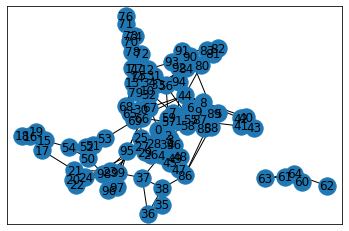

In [4]:
"""
An example on either a Barabasi network of preferential attachment or a planted
partition model
"""
random.seed(1245)
N = 10
G = nx.planted_partition_graph(int(N*2), int(N/2), 0.8, 0.01)
for edge in G.edges():
    (u, v) = edge
    G.edges[u,v]['weight'] = np.random.rand(1)
Adj = nx.to_numpy_array(G)
pos = nx.spring_layout(G, seed=46)
nx.draw_networkx(G, pos)

M = G.nodes()
m_seed = np.random.choice(M, 1)[0]


Innovators, NotInnovators, NotExposed, m_seed, Innovation = InnovationGen(G)

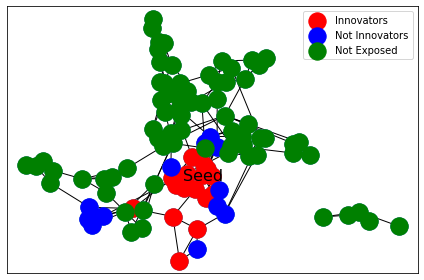

In [5]:
"""
Plotting the example produced above
"""
random.seed(123)
fig, ax = plt.subplots(facecolor="w")
pos = nx.spring_layout(G, seed=46)
nx.draw_networkx(G, pos, ax = ax,with_labels=False)
nx.draw_networkx_nodes(G, pos, nodelist=Innovators, node_color="r", ax = ax, label="Innovators")
nx.draw_networkx_nodes(G, pos, nodelist=NotInnovators, node_color="b", ax = ax, label="Not Innovators")
nx.draw_networkx_nodes(G, pos, nodelist=NotExposed, node_color="g", ax = ax, label="Not Exposed")
nx.draw_networkx_labels(G, pos, {m_seed:"Seed"},font_size=16)
plt.legend()
plt.tight_layout()


In [6]:
"""
Run a Monte Carlo simulation with 100 draws from the DGP. On each graph select 25
nodes randomly and calculate the innovation level given that starting point.
This is then aggregated as to approach the limiting distribution under the Monte Carlo
assumptions.
"""

monte = 1
seed_betweenness_dist = []
total_innovation_dist = []
seed_weighted_degree_dist = []
seed_eigenvector_dist = []

while monte < 1000:

    num = 1
    seed_betweenness = []
    total_innovation = []
    seed_weighted_degree = []
    seed_eigenvector = []

    """
    Select which graphing style to use by uncommenting either one.
    """
    G = nx.planted_partition_graph(int(N*2), int(N/2), 0.8, 0.01)
    #G = nx.barabasi_albert_graph(100, 4)

    """ Add weights to each edge drawn from a uniform distribution on [0, 1]"""

    for edge in G.edges():
        (u, v) = edge
        G.edges[u,v]['weight'] = np.random.rand(1)

    while num <= 5:

        Innovators, NotInnovators, NotExposed, m_seed, Innovation = InnovationGen(G)

        betweenness = nx.betweenness_centrality(G, normalized=False, weight='weight')
        bet_seed = betweenness[m_seed]
        seed_betweenness.append(bet_seed)

        """
        A simple process to calculate the weighted degree of a node.
        Rather than summing the number of edges, simply sum the weights.
        """
        Adj = nx.to_numpy_array(G)
        weighted_degree = np.sum(Adj[m_seed, :])
        seed_weighted_degree.append(weighted_degree)

        eigenvector = nx.eigenvector_centrality_numpy(G)
        eig_seed = eigenvector[m_seed]
        seed_eigenvector.append(eig_seed)

        sum_innovation = sum(dict_values(Innovation.values()))
        total_innovation.append(sum_innovation)

        num = num+1

    seed_betweenness = np.array(seed_betweenness)
    seed_weighted_degree = np.array(seed_weighted_degree)
    seed_eigenvector = np.array(seed_eigenvector)

    seed_betweenness_dist.append(seed_betweenness)
    total_innovation_dist.append(total_innovation)
    seed_weighted_degree_dist.append(seed_weighted_degree)
    seed_eigenvector_dist.append(seed_eigenvector)

    monte =monte+1

seed_betweenness_dist = np.array(seed_betweenness_dist)
total_innovation_dist = np.array(total_innovation_dist)
seed_weighted_degree_dist = np.array(seed_weighted_degree_dist)
seed_eigenvector_dist = np.array(seed_eigenvector_dist)

seed_betweenness = np.mean(seed_betweenness_dist, axis=1)
seed_eigenvector = np.mean(seed_eigenvector_dist, axis=1)
seed_weighted_degree = np.mean(seed_weighted_degree_dist, axis=1)
total_innovation = np.mean(total_innovation_dist, axis=1)

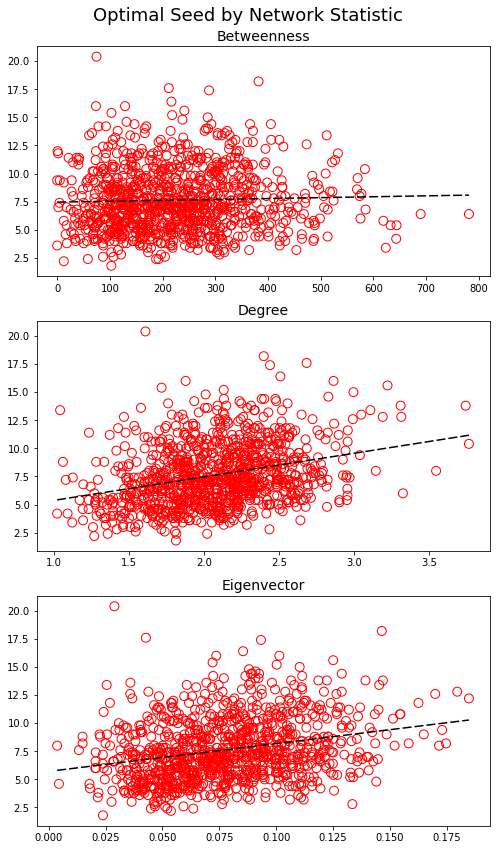

In [8]:
"""
Plot the correlation between the betweenness, weighted degree and eigenvector
centrality of the seeding node and the overall innovation accumulation rate
"""

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, facecolor="w", figsize=(7,12))
fig.suptitle("Optimal Seed by Network Statistic", fontsize=18)
ax1.scatter(seed_betweenness, total_innovation,  s=80, facecolors='none', edgecolors='r')
ax1.set_title("Betweenness", fontsize=14)
ax1.plot(np.unique(seed_betweenness),
         np.poly1d(np.polyfit(seed_betweenness, total_innovation, 1))(np.unique(seed_betweenness)),
         color="k", dashes=[6, 2])

ax2.scatter(seed_weighted_degree, total_innovation, s=80, facecolors='none', edgecolors='r')
ax2.set_title("Degree", fontsize=14)
ax2.plot(np.unique(seed_weighted_degree),
         np.poly1d(np.polyfit(seed_weighted_degree, total_innovation, 1))(np.unique(seed_weighted_degree)),
         color="k", dashes=[6, 2])
ax3.scatter(seed_eigenvector, total_innovation, s=80, facecolors='none', edgecolors='r')
ax3.set_title("Eigenvector", fontsize=14)
ax3.plot(np.unique(seed_eigenvector),
         np.poly1d(np.polyfit(seed_eigenvector, total_innovation, 1))(np.unique(seed_eigenvector)),
         color="k", dashes=[6, 2])
fig.savefig("Planted Partiton Graph 1000")
plt.tight_layout()

In [190]:
for edge in G.edges():
    (u, v) = edge
    G.edges[u,v]['weight'] = float(np.around(G.edges[u,v]['weight']*10))

In [196]:
Adj = nx.to_numpy_array(G)

In [192]:
"""
Add an attribute indicating whether that node innovated to display such information
later on in the figure.
"""
for node in G.nodes:
    if node in Innovators:
        G.nodes[node]["Innovate"] = 1
    elif node in NotInnovators:
        G.nodes[node]["Innovate"] = 2
    elif node in NotExposed:
        G.nodes[node]["Innovate"] = 3

nx.write_gexf(G, "Graph.gexf")

In [ ]:
"""
Extra code, I will delete this if not used however it does provide other
interesting alternatives to modelling the industry structure.
"""

"""
Stochastic Graph
# Method 1
N = 10
sizes = np.random.randint(3, 5, N)
idx = np.random.randint(0, 2, (N, N))
idx = np.tril(idx) + np.tril(idx, -1).T

Adj = np.random.rand(N,N)
Adj = (Adj + Adj.T)/2
Adj[idx == 1] = 0

# Method 2
E = np.ones((N, N))/10
p_in = 0.49
ps = [p_in]*N
Adj = np.diag(ps)

Adj = Adj + E
G = nx.generators.community.stochastic_block_model(sizes, Adj)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
nx.write_gexf(G, "Graph.gexf")
check = nx.to_numpy_array(G)
"""


In [193]:
m_seed



61